In [91]:
# Author: Davide Aloi - PhD student - University of Birmingham
# Description: Script to clean T1 / T2 files before running roast simulations. This is 
# necessary as some scans have the cod liver oil, which ROAST segments as skull.

import numpy as np
import nilearn
import os
import glob

In [92]:
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 
output_folder = 'D:\\roast-chapter3\\wp_all_results\\' # where to save results
data_folder = 'D:\\roast-chapter3\\'

# Datasets names and subjects lists
db_names = ['wp2a', 'wp1a', 'wp1b']
db_names = ['wp2a']

db_subjects = [['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']]         
db_subjects = [['02']]                    

D:\roast-chapter3\wp2a\sub-01
(70.95012315270937, 82.88977832512315, 219.3097290640394)
D:\roast-chapter3\wp2a\sub-02
(69.2522842639594, 166.39238578680204, 95.27360406091371)
D:\roast-chapter3\wp2a\sub-03
(32.69879518072289, 85.22672508214677, 198.03395399780942)
D:\roast-chapter3\wp2a\sub-04
(34.134453781512605, 111.10714285714286, 206.1638655462185)
D:\roast-chapter3\wp2a\sub-06
(30.502061855670103, 80.52886597938145, 194.40412371134022)
D:\roast-chapter3\wp2a\sub-07
(35.15157480314961, 95.13385826771653, 200.10433070866142)
D:\roast-chapter3\wp2a\sub-08
(37.52122448979592, 74.0930612244898, 182.99755102040817)


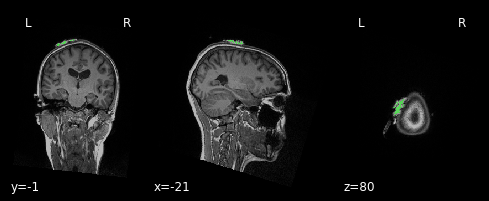

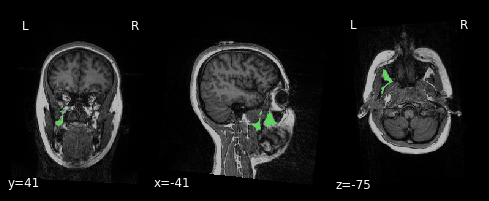

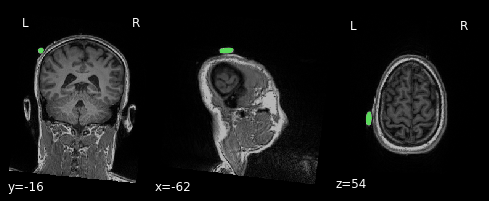

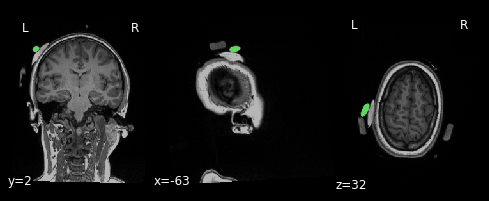

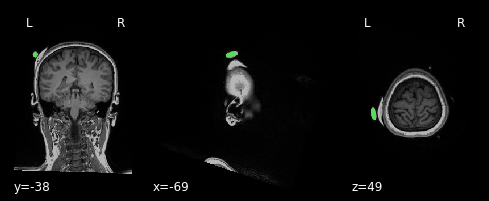

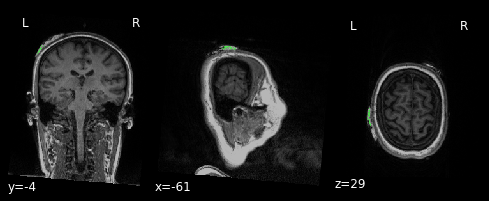

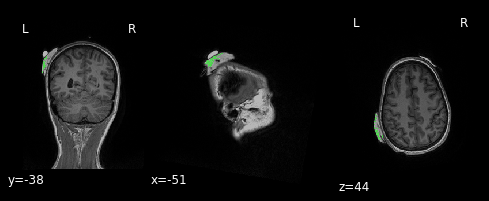

In [93]:
from nilearn import image
from skimage import measure
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
import cupy as cp
from scipy import ndimage

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in enumerate(db_subjects[db_id]): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)
        th = 3500 # threshold for binarising T1

        #Loading and binarising t1
        T1 = image.load_img(glob.glob(path + '\sub-*T1.nii'))
        T1_data = T1.get_fdata().reshape(T1.shape[0:3])
        T1 = new_img_like(T1, T1_data)
        T1_bin = np.where(T1.get_fdata() > th, 1, 0)

        arr = measure.label(T1_bin, connectivity = 1)

        # Running this on GPU using cupy instead of numpy
        T1_bin_cp = cp.array(T1_bin)
        arr_cp = cp.array(arr)

        for i in cp.unique(arr_cp[arr_cp!=0]):
            if (T1_bin_cp[arr_cp == i]).sum() < 500:
              arr_cp[arr_cp==i] = 0

        arr = cp.asnumpy(arr_cp)

        cdl = np.where(arr == np.unique(arr)[2], 1, 0)
        peak = ndimage.measurements.center_of_mass(cdl)
        print(peak)
        
        # Coordinate of cod liver oil / electrode
        peak_mni = nilearn.image.coord_transform(peak[0],peak[1],peak[2], T1.affine)
        display = plot_anat(T1, cut_coords = peak_mni, draw_cross = False)   
        display.add_overlay(new_img_like(T1, cdl), cmap = 'green_transparent')


In [ ]:
new_img_like(T1, cdl).to_filename(os.path.join(output_folder, db, subject + '_cod_liver_seg.nii'))